# Drift Detector

## Utils: 

- Density based clustering
- Nearest-cluster centroids

In [1]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np
from torchvision import transforms
import torch
import clip
import matplotlib.pyplot as plt
import pickle
from PIL import Image
from rich import print
from scipy.stats import trim_mean


def find_avg_centroid(x):
    return np.mean(x, axis=0)

def trimmed_mean_centroid(x, proportion_to_cut=0.1):
    """
    Compute the trimmed mean centroid of an array of points.
    """
    return trim_mean(x, proportiontocut=proportion_to_cut, axis=0)

def find_better_centroid(x):
    return trimmed_mean_centroid(x)

def find_nearest_centroids(x, y):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = x.detach().cpu().numpy()
        
    clf = NearestCentroid(metric='manhattan')
    clf = clf.fit(x, y)
    centroids = clf.centroids_
    return centroids

def find_knn(x, centroids, n_neighbors=10):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = x.detach().cpu().numpy()

    knn_search = NearestNeighbors(n_neighbors=n_neighbors,
                            metric='manhattan', 
                            algorithm='auto', #'ball_tree'
                            n_jobs=-1)  
    knn_search.fit(x)

    indexes = knn_search.kneighbors(centroids, return_distance=False)
    return x[indexes][0]

        
def get_clusters(x):
    db = DBSCAN(eps=0.3, min_samples=10, leaf_size=30, 
                n_jobs=-1, metric='cosine').fit(x)

    # core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    # core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    if n_clusters_ == 0:
        return x, labels, n_clusters_
    # Remove outliers to avoid affecting the centroids
    x = x[np.where(labels != -1)]
    labels = labels[np.where(labels != -1)]
    
    return x, labels, n_clusters_


def get_nearest_embedding_centroids(x, n_neighbors=10):
    
    #1. Get the CLIP embeddings
    if not isinstance(x, (np.ndarray, np.generic)):
        x = x.detach().cpu().numpy()
    
    #2. Cluster the embeddings
    x, labels, n_clusters = get_clusters(x)

    #3. Find centroids of embeddings
    if n_clusters < 2:
        # centroids = find_avg_centroid(x)
        centroids = find_better_centroid(x)
        centroids = centroids.reshape(1, -1)
    else:
        centroids = find_nearest_centroids(x, labels)

    # If some infinite/nan values appear
    centroids = np.nan_to_num(centroids)
    #4. Find knn of centroids        
    x_nearest_centroids = find_knn(x, centroids, n_neighbors)
    x_chosen = np.vstack([centroids, x_nearest_centroids])

    print(f"# nearest centroids ({round((x_chosen.shape[0]/x.shape[0])*100, 2)}%):", x_chosen.shape)
    print()

    return x_chosen


### Semantic embedding

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)
embeder, preprocess = clip.load("ViT-B/32", device=device)

Device:  cpu

In [3]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, util
from functools import lru_cache

@lru_cache(maxsize=None)
def get_embeddings(dataset):
    
    all_features = []
    all_labels = []
    all_tasks = []
    
    with torch.no_grad():
        for images, labels, tasks in tqdm(DataLoader(dataset, batch_size=100, num_workers=8)):
            features = embeder.encode_image(images.to(device))
            # features = embeder_resnet(images.to(device)).squeeze()

            all_features.append(features)
            all_labels.append(labels)
            all_tasks.append(tasks)

    return (torch.cat(all_features).cpu().numpy(), 
            torch.cat(all_labels).cpu().numpy(), torch.cat(all_tasks).cpu().numpy())


## Obtain the SODA10M dataset

In [4]:
import sys
sys.path.append('./CLAD/')

import clad
import torchvision

root = "./data"
original_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.3252, 0.3283, 0.3407), (0.0265, 0.0241, 0.0252))

])

# all_train_sets = clad.get_cladc_train(root, transform=lambda x: x)
all_train_sets = clad.get_cladc_train(root, transform=original_transform)
# val_sets = clad.get_cladc_val(root, transform=torchvision.transforms.ToTensor())
print(len(all_train_sets))
print([len(ts) for ts in all_train_sets])

[INFO] No Detectron installation found, continuing without.


6

[5157, 1154, 6742, 2560, 4517, 2119]

In [5]:
# method_transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.ToPILImage()
# ])
method_transform = torchvision.transforms.Compose([
    preprocess
])
all_train_sets_method = clad.get_cladc_train(root, transform=method_transform)
print(len(all_train_sets_method))
print([len(ts) for ts in all_train_sets_method])

6

[5157, 1154, 6742, 2560, 4517, 2119]

### Train/Test split

In [6]:
import torch
from torch.utils.data import random_split

# Define the split sizes for each dataset
train_size = 0.8
# test_size = 0.2

# Split each dataset in the train_sets list into training and testing sets
train_sets = []
test_sets = []
for dataset in all_train_sets:
    dataset_size = len(dataset)
    train_dataset_size = int(train_size * dataset_size)
    test_dataset_size = dataset_size - train_dataset_size
    train_dataset, test_dataset = random_split(dataset, [train_dataset_size, test_dataset_size], 
                                               generator=torch.Generator().manual_seed(42))
    train_sets.append(train_dataset)
    test_sets.append(test_dataset)

print("Original data")
print('Training lenghts: ', [len(ts) for ts in train_sets])
print('Testing lenghts: ', [len(ts) for ts in test_sets])

train_sets_method = []
test_sets_method = []
for dataset in all_train_sets_method:
    dataset_size = len(dataset)
    train_dataset_size = int(train_size * dataset_size)
    test_dataset_size = dataset_size - train_dataset_size
    train_dataset, test_dataset = random_split(dataset, [train_dataset_size, test_dataset_size], 
                                               generator=torch.Generator().manual_seed(42))
    train_sets_method.append(train_dataset)
    test_sets_method.append(test_dataset)

print("Method data")
print('Training lenghts: ', [len(ts) for ts in train_sets_method])
print('Testing lenghts: ', [len(ts) for ts in test_sets_method])

Original data

Training lenghts: 
[4125, 923, 5393, 2048, 3613, 1695]

Testing lenghts: 
[1032, 231, 1349, 512, 904, 424]

Method data

Training lenghts: 
[4125, 923, 5393, 2048, 3613, 1695]

Testing lenghts: 
[1032, 231, 1349, 512, 904, 424]

In [7]:
%%time
from torch.utils.data.dataset import TensorDataset
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.utils import make_classification_dataset
from torch.utils.data import DataLoader
from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark



# Original benchmark with tasks
training_datasets = list()
testing_datasets = list()

for task, (train_s, test_s) in enumerate(zip(train_sets, test_sets), start=0):
    training_datasets.append(make_classification_dataset(train_s, task_labels=np.repeat(task, len(train_s))))
    testing_datasets.append(make_classification_dataset(test_s, task_labels=np.repeat(task, len(test_s))))

benchmark= dataset_benchmark(
    training_datasets,
    testing_datasets
)

# Original benchmark without tasks
training_datasets = list()
testing_datasets = list()
for task, (train_s, test_s) in enumerate(zip(train_sets, test_sets), start=0):
    training_datasets.append(make_classification_dataset(train_s, task_labels=np.repeat(0, len(train_s))))
    testing_datasets.append(make_classification_dataset(test_s, task_labels=np.repeat(0, len(test_s))))

benchmark_no_task= dataset_benchmark(
    training_datasets,
    testing_datasets
)

# Method benchmark
training_datasets = list()
testing_datasets = list()
for task, (train_s, test_s) in enumerate(zip(train_sets_method, test_sets_method), start=0):
    training_datasets.append(make_classification_dataset(train_s, task_labels=np.repeat(task, len(train_s))))
    testing_datasets.append(make_classification_dataset(test_s, task_labels=np.repeat(task, len(test_s))))

benchmark_method= dataset_benchmark(
    training_datasets,
    testing_datasets
)

CPU times: user 548 ms, sys: 86.4 ms, total: 634 ms
Wall time: 675 ms


## Data preparation

In [8]:
train_stream = benchmark_method.train_stream
test_stream = benchmark_method.test_stream

all_x_train_emb = list()
all_y_train = list()
all_t_train = list()

all_x_test_emb = list()
all_y_test = list()
all_t_test = list()


for task, experience in enumerate(train_stream):
    print("Getting embeddings")
    x_train_emb, y_train, t_train = get_embeddings(train_stream[task].dataset)

    print("x_train shape: ", x_train_emb.shape)
    all_x_train_emb.append(x_train_emb)
    all_y_train.append(y_train)
    all_t_train.append(t_train)

    x_test_emb, y_test, t_test = get_embeddings(test_stream[task].dataset)
    print("x_test shape: ", x_test_emb.shape)
    all_x_test_emb.append(x_test_emb)
    all_y_test.append(y_test)
    all_t_test.append(t_test)

Getting embeddings

100%|██████████| 42/42 [01:29<00:00,  2.12s/it]


x_train shape: 
(4125, 512)

100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


x_test shape: 
(1032, 512)

Getting embeddings

100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


x_train shape: 
(923, 512)

100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


x_test shape: 
(231, 512)

Getting embeddings

100%|██████████| 54/54 [02:09<00:00,  2.40s/it]


x_train shape: 
(5393, 512)

100%|██████████| 14/14 [00:17<00:00,  1.22s/it]


x_test shape: 
(1349, 512)

Getting embeddings

100%|██████████| 21/21 [00:29<00:00,  1.42s/it]


x_train shape: 
(2048, 512)

100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


x_test shape: 
(512, 512)

Getting embeddings

100%|██████████| 37/37 [01:17<00:00,  2.09s/it]


x_train shape: 
(3613, 512)

100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


x_test shape: 
(904, 512)

Getting embeddings

100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


x_train shape: 
(1695, 512)

100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


x_test shape: 
(424, 512)

## Calculate drift to all the tasks

In [11]:
from alibi_detect.cd import MMDDrift
from timeit import default_timer as timer

labels = ['No!', 'Yes!']


num_classes = 6
track_values = []
for task_a_id, task_a in enumerate(all_x_train_emb[:num_classes]):
    x_ref = get_nearest_embedding_centroids(task_a, n_neighbors=10)
    cd = MMDDrift(x_ref, backend='pytorch', device=device)
    drifts = []
    for task_b_id, task_b in enumerate(all_x_train_emb[:num_classes]):
        x_new = get_nearest_embedding_centroids(task_b, n_neighbors=10)
        t = timer()
        preds = cd.predict(x_new)
        dt = timer() - t

        print(f"Task {task_a_id} vs Task {task_b_id}")
        drift = 0 if preds['data']['distance'] < 0 else 1
        print('Drift? {}'.format(labels[drift]))
        print(f'p-value: {preds["data"]["p_val"]:.3f}')
        print(f'Time (s) {dt:.3f}')
        print()
        drifts.append(preds['data']['distance'])
    track_values.append(drifts)
    
track_values

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Task 0 vs Task 0

Drift? No!

p-value: 0.990

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (1.19%):
(11, 512)

Task 0 vs Task 1

Drift? Yes!

p-value: 0.000

Time (s) 0.011

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.2%):
(11, 512)

Task 0 vs Task 2

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.54%):
(11, 512)

Task 0 vs Task 3

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.3%):
(11, 512)

Task 0 vs Task 4

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.65%):
(11, 512)

Task 0 vs Task 5

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (1.19%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Task 1 vs Task 0

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (1.19%):
(11, 512)

Task 1 vs Task 1

Drift? No!

p-value: 1.000

Time (s) 0.010

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.2%):
(11, 512)

Task 1 vs Task 2

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.54%):
(11, 512)

Task 1 vs Task 3

Drift? Yes!

p-value: 0.080

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.3%):
(11, 512)

Task 1 vs Task 4

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.65%):
(11, 512)

Task 1 vs Task 5

Drift? Yes!

p-value: 0.000

Time (s) 0.008

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.2%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Task 2 vs Task 0

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (1.19%):
(11, 512)

Task 2 vs Task 1

Drift? Yes!

p-value: 0.000

Time (s) 0.009

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.2%):
(11, 512)

Task 2 vs Task 2

Drift? No!

p-value: 0.990

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.54%):
(11, 512)

Task 2 vs Task 3

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.3%):
(11, 512)

Task 2 vs Task 4

Drift? Yes!

p-value: 0.010

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.65%):
(11, 512)

Task 2 vs Task 5

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.54%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Task 3 vs Task 0

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (1.19%):
(11, 512)

Task 3 vs Task 1

Drift? Yes!

p-value: 0.060

Time (s) 0.008

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.2%):
(11, 512)

Task 3 vs Task 2

Drift? Yes!

p-value: 0.000

Time (s) 0.008

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.54%):
(11, 512)

Task 3 vs Task 3

Drift? No!

p-value: 1.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.3%):
(11, 512)

Task 3 vs Task 4

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.65%):
(11, 512)

Task 3 vs Task 5

Drift? Yes!

p-value: 0.000

Time (s) 0.008

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.3%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Task 4 vs Task 0

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (1.19%):
(11, 512)

Task 4 vs Task 1

Drift? Yes!

p-value: 0.000

Time (s) 0.008

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.2%):
(11, 512)

Task 4 vs Task 2

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.54%):
(11, 512)

Task 4 vs Task 3

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.3%):
(11, 512)

Task 4 vs Task 4

Drift? No!

p-value: 1.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.65%):
(11, 512)

Task 4 vs Task 5

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.65%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Task 5 vs Task 0

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (1.19%):
(11, 512)

Task 5 vs Task 1

Drift? Yes!

p-value: 0.000

Time (s) 0.008

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.2%):
(11, 512)

Task 5 vs Task 2

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.54%):
(11, 512)

Task 5 vs Task 3

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.3%):
(11, 512)

Task 5 vs Task 4

Drift? Yes!

p-value: 0.000

Time (s) 0.007

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.65%):
(11, 512)

Task 5 vs Task 5

Drift? No!

p-value: 1.000

Time (s) 0.007

[[-0.11577409505844116,
  0.4580276608467102,
  0.2387259304523468,
  0.4738098978996277,
  0.32154136896133423,
  0.4939245283603668],
 [0.4506462514400482,
  -0.11225932836532593,
  0.32017165422439575,
  0.02478712797164917,
  0.3874644935131073,
  0.1300404667854309],
 [0.2550978660583496,
  0.3439701795578003,
  -0.11186540126800537,
  0.3441591262817383,
  0.037298738956451416,
  0.39842283725738525],
 [0.4652169644832611,
  0.024769246578216553,
  0.3213465213775635,
  -0.11193645000457764,
  0.3751175105571747,
  0.13419759273529053],
 [0.3307185769081116,
  0.4042793810367584,
  0.036168813705444336,
  0.3901992738246918,
  -0.11333519220352173,
  0.481010377407074],
 [0.47496145963668823,
  0.1294182538986206,
  0.35904332995414734,
  0.13336646556854248,
  0.44754478335380554,
  -0.11322259902954102]]

## Make a table and confusion matrix

In [99]:
import pandas as pd

cols = [f"Task {i}" for i in range(1, len(all_x_train_emb)+1)]
df = pd.DataFrame(track_values, columns=cols, index=cols)
# df.set_index(['Task1', 'Task2', 'Task3', 'Task4'])
df

,Task 1,Task 2,Task 3,Task 4,Task 5,Task 6
Task 1,-0.115774,0.458028,0.238726,0.473810,0.321541,0.493925
Task 2,0.450646,-0.112259,0.320172,0.024787,0.387464,0.130040
Task 3,0.255098,0.343970,-0.111865,0.344159,0.037299,0.398423
Task 4,0.465217,0.024769,0.321347,-0.111936,0.375118,0.134198
Task 5,0.330719,0.404279,0.036169,0.390199,-0.113335,0.481010
Task 6,0.474961,0.129418,0.359043,0.133366,0.447545,-0.113223


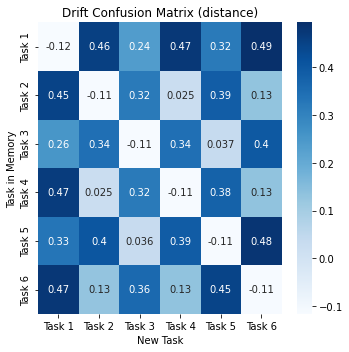

In [100]:
import seaborn as sns
confusion_matrix = df.to_numpy()
# Plotting the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', xticklabels=cols, yticklabels=cols, )
plt.xlabel('New Task')
plt.ylabel('Task in Memory')
plt.title('Drift Confusion Matrix (distance)')
plt.tight_layout()
plt.savefig('drift_confusion_matrix.pdf', bbox_inches='tight', pad_inches=0)
plt.show()